- https://www.tensorflow.org/text/tutorials/image_captioning
- https://www.tensorflow.org/api_docs/python/tfm/nlp/models/TransformerDecoder
- https://keras.io/examples/vision/image_captioning


In [1]:
import sys
print(sys.executable)


/root/miniconda3/envs/tf-gpu/bin/python


1. load paris dataset
2. prepare caption & vectorizer
3. build dataset
4. build visual encoder
5. build transformer decoder
6. build wrapper(encoder + decoder)
7. loss masking
8. training
9. test (inference loop)

In [2]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
import re, string
import keras
import collections

import os, json, time, cv2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, ResNet50V2, resnet_v2, EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

2025-12-07 21:16:35.050518: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 21:16:35.252563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-07 21:16:35.330659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-07 21:16:35.350815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-07 21:16:35.500417: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# HYPERPARAMS
D_MODEL = 512
NUM_HEADS=4
DFF= 2048
NUM_LAYERS=4
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=32
# SEQ_IMG = None
LR=1e-4


In [4]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1765116998.485974     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765116998.774810     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765116998.774996     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
print(tf.__version__)

2.17.0


# 1. Load COCO2017

In [6]:
json_path = "data/coco2017/annotations/annotations/captions_train2017_subset.json"

with open(json_path, "r") as f:
  data=json.load(f)

print(data["annotations"][0].keys())

images_df = pd.DataFrame(data['images'])
annotations_df = pd.DataFrame(data['annotations'])

# gabungkan berdasarkan image_id
merged_df = annotations_df.merge(images_df, left_on='image_id', right_on='id', suffixes=('_caption', '_image'))

# tampilkan kolom penting
df = merged_df[['image_id', 'file_name', 'caption']]
print(df.head())



dict_keys(['image_id', 'id', 'caption'])
   image_id         file_name  \
0    203564  000000203564.jpg   
1    322141  000000322141.jpg   
2     16977  000000016977.jpg   
3    106140  000000106140.jpg   
4    106140  000000106140.jpg   

                                             caption  
0  A bicycle replica with a clock as the front wh...  
1  A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind...  
3  A large passenger airplane flying through the ...  
4  There is a GOL plane taking off in a partly cl...  


In [7]:
import pandas as pd
pd.DataFrame(data["annotations"]).head()


,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


### 1. Load COCO2017

In [8]:
base_dir="./data/coco2017"

train_img_dir = os.path.join(base_dir, "images", "train2017_subset")
train_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_train2017_subset.json")

def load_coco_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f)

  images ={img['id']: img['file_name'] for img in ann['images']}
  pairs=[]

  annots = ann['annotations']

  for item in annots:
    img_id = item['image_id']
    img_path = os.path.join(img_dir, images[img_id])
    caption = item['caption']

    if os.path.exists(img_path):
      # VALIDASI
      assert isinstance(img_path, str), f"img_path bukan string: {img_path}"
      assert isinstance(caption, str), f"caption bukan string: {caption}"
      pairs.append((img_path, caption))

  return pairs

# pairs = load_coco_pairs(train_img_dir, train_ann_path)
# print("tot data loaded dr local= ", len(pairs))

# if len(pairs)>0:
#   print("cth: ", pairs[:2])


In [9]:
base_dir="./data/coco2017"

# load all validation data
val_img_dir = os.path.join(base_dir, "images", "val2017", "val2017")
val_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_val2017.json")

# val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

# print("tot validation loaded dr local= ", len(val_pairs))

# if len(val_pairs)>0:
#   print("cth: ", val_pairs[:2])

In [10]:
# 1. load coco pairs
train_pairs = load_coco_pairs(train_img_dir, train_ann_path)
val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

### grouped load coco

In [11]:
from collections import Counter

counter = Counter([p[0] for p in train_pairs])
print(counter.most_common(5))


[('./data/coco2017/images/train2017_subset/000000336464.jpg', 7), ('./data/coco2017/images/train2017_subset/000000075663.jpg', 6), ('./data/coco2017/images/train2017_subset/000000411564.jpg', 6), ('./data/coco2017/images/train2017_subset/000000438258.jpg', 6), ('./data/coco2017/images/train2017_subset/000000027065.jpg', 6)]


In [12]:
print(train_pairs[:5])
print(type(train_pairs[0][0]), type(train_pairs[0][1]))


[('./data/coco2017/images/train2017_subset/000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), ('./data/coco2017/images/train2017_subset/000000322141.jpg', 'A room with blue walls and a white sink and door.'), ('./data/coco2017/images/train2017_subset/000000016977.jpg', 'A car that seems to be parked illegally behind a legally parked car'), ('./data/coco2017/images/train2017_subset/000000106140.jpg', 'A large passenger airplane flying through the air.'), ('./data/coco2017/images/train2017_subset/000000106140.jpg', 'There is a GOL plane taking off in a partly cloudy sky.')]
<class 'str'> <class 'str'>


### 2.preprocess caption & vectorizer
- vectorizer_data = vectorizer yg disave

In [13]:
# def standardize(s):
#   s = tf.strings.lower(s)
#   s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
#   s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
#   return s
def custom_standardization(input_string):
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


In [14]:
def build_text_vectorizer(pairs, max_length=20):
  captions =[f"<start> {cap} <end>" for _, cap in pairs]

  # 1. layer teks vectorizer(ubah dlm bentuk numerik)
  vectorizer = tf.keras.layers.TextVectorization(
      max_tokens = VOCAB_SIZE, # end & start
      output_sequence_length = max_length,
      standardize=custom_standardization,
      output_mode="int"
  )
  vectorizer.adapt(captions)

  vocab = vectorizer.get_vocabulary()
  print("vocab size: ", len(vocab))
  print("First token: ", vocab[:10])
  
  # index_lookup=dict(zip(range(len(vocab_final_list)), vocab_final_list))
  # save vocab (utk inference)
  with open('vectorizer_data.pkl', "wb") as f:
    pickle.dump({
        "vocab":vocab,
        "max_length": max_length,
        "max_vocab_size": VOCAB_SIZE
    }, f)

  return vectorizer

In [15]:
# def build_text_vectorizer_adapt(pairs, max_length=20, max_vocab_size=5000):
#   text_ds = tf.data.Dataset.from_tensor_slices([c for _,c in pairs])
#   vectorizer = tf.keras.layers.TextVectorization(
#       max_tokens=max_vocab_size,
#       standardize=standardize,
#       output_sequence_length=max_length
#   )
#   vectorizer.adapt(text_ds)
#   return vectorizer
vectorizer=build_text_vectorizer(train_pairs)
print(vectorizer("a cat sitting on a mat"))

I0000 00:00:1765117152.710774     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765117152.710882     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765117152.710901     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765117152.927149     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765117152.927268     947 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-07

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']
tf.Tensor(
[   2   59   15    6    2 1487    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)


In [16]:
# cek masking
vec = vectorizer("a cat sitting on a mat")
print(vec)
print(vec==0)

tf.Tensor(
[   2   59   15    6    2 1487    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)
tf.Tensor(
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True], shape=(20,), dtype=bool)


In [17]:
img_paths = [p[0] for p in train_pairs]
print(img_paths[:3])

capt=[p[1] for p in train_pairs]
print(capt[:3])

['./data/coco2017/images/train2017_subset/000000203564.jpg', './data/coco2017/images/train2017_subset/000000322141.jpg', './data/coco2017/images/train2017_subset/000000016977.jpg']
['A bicycle replica with a clock as the front wheel.', 'A room with blue walls and a white sink and door.', 'A car that seems to be parked illegally behind a legally parked car']


In [18]:
def decode_tokens_to_text(token_ids, vectorizer_layer):

    vocab_list = vectorizer_layer.get_vocabulary()

    ids_to_words = np.vectorize(lambda idx: vocab_list[idx] if idx < len(vocab_list) else "[MISS]")

    words = ids_to_words(token_ids)

    filtered= [w for w in words if w != '']

    return " ".join(filtered)

In [19]:
# vocab
vocab = vectorizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))

sentence = "my dog play in backyard"
tokenized_sent = vectorizer([sentence])

print("sentence : ",sentence)
print("output token ID : ", tokenized_sent.numpy())

# konvert ID -> sentence lg
token_ids = tokenized_sent.numpy()[0] # Ambil array ID pertama dari batch
decoded = decode_tokens_to_text(token_ids, vectorizer)
print("returned text= ", decoded)

# decoded = decode_tokens_to_text(token)
# print("Output index to word: ",index_lookup[10])

sentence :  my dog play in backyard
output token ID :  [[7216   73 1231    8 3146    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
returned text=  my dog play in backyard


In [20]:
print(vectorizer('<start> a dog running <end>'))
print([vocab[i] for i in vectorizer('<start> a dog running <end>')])

tf.Tensor(
[  3   2  73 439   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)
['<start>', 'a', 'dog', 'running', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [21]:
# Debugging Vectorizer untuk memastikan <start> dan <end> ada
def debug_vectorizer(vectorizer, sample_captions):

    vocab = vectorizer.get_vocabulary()
    print("=== Vocabulary Info ===")
    print("Vocab size:", len(vocab))
    print("First 20 tokens:", vocab[:20])

    # Cek apakah <start> dan <end> ada
    print("\nCheck special tokens in vocab:")
    print("<start> in vocab?", "<start>" in vocab)
    print("<end> in vocab?", "<end>" in vocab)

    # Tokenisasi beberapa caption contoh
    print("\n=== Tokenized samples ===")
    for cap in sample_captions:
        tokens = vectorizer([cap])
        print(f"Original: {cap}")
        print(f"Token IDs: {tokens.numpy()[0]}")  # ambil 1 batch
        # Reverse lookup untuk cek hasil token
        id_to_token = dict(zip(range(len(vocab)), vocab))
        token_words = [id_to_token[i] for i in tokens.numpy()[0] if i != 0]
        print(f"Decoded tokens: {token_words}\n")

# Contoh penggunaan
sample_captions = [
    "<start> a dog is running <end>",
    "<start> a cat is sleeping <end>"
]

debug_vectorizer(vectorizer, sample_captions)


=== Vocabulary Info ===
Vocab size: 9521
First 20 tokens: ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with', 'and', 'is', 'to', 'street', 'an', 'sitting', 'bathroom', 'next', 'white', 'man']

Check special tokens in vocab:
<start> in vocab? True
<end> in vocab? True

=== Tokenized samples ===
Original: <start> a dog is running <end>
Token IDs: [  3   2  73  11 439   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Decoded tokens: ['<start>', 'a', 'dog', 'is', 'running', '<end>']

Original: <start> a cat is sleeping <end>
Token IDs: [  3   2  59  11 512   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Decoded tokens: ['<start>', 'a', 'cat', 'is', 'sleeping', '<end>']



### 3. Build dataset

In [22]:
# preprocess efficient net
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess

# data pipeline
def caption_to_tokens(caption, vectorizer,max_len = MAX_CAP_LEN):
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)
    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    return token
    
def preprocess_input(img_path, caption, vectorizer, max_len=MAX_CAP_LEN):
    # 1. img preprocess
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img_converted = efficient_preprocess(img)
    # img_converted = tf.image.convert_image_dtype(img, tf.float32)
    # img_converted = tf.cast(img, tf.float32)/255.0

    # 2. tokenize caption
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)

    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    dec_in=token[:-1]
    dec_out = token[1:]

    return img_converted, dec_in, dec_out

def generate_dataset(pairs, vectorizer, batch_size=BATCH_SIZE):
    img_paths = [p[0] for p in pairs]
    captions=[p[1] for p in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))

    @tf.function
    def map_function(ip, cap):
        img, dec_in, dec_out = preprocess_input(ip, cap, vectorizer)
        return (img, dec_in), dec_out
    
    dataset = dataset.map(
        map_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [23]:
x = caption_to_tokens("a man riding a horse", vectorizer)
x.shape


TensorShape([20])

In [24]:
vectorizer=build_text_vectorizer(train_pairs, max_length=20)

train_data = generate_dataset(train_pairs,vectorizer)
val_data = generate_dataset(val_pairs,vectorizer)

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']


In [25]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    print("img_batch : ", img_batch.shape)
    print("dtype img_batch : ", img_batch.dtype)
    print("dec_in batch shape : ", dec_in_batch.shape)
    print("dec_out batch shape : ", dec_out_batch.shape)
    
    print(f"Nilai min piksel dalam batch: {tf.reduce_min(img_batch).numpy()}")
    print(f"Nilai max piksel dalam batch: {tf.reduce_max(img_batch).numpy()}")

    

img_batch :  (32, 224, 224, 3)
dtype img_batch :  <dtype: 'float32'>
dec_in batch shape :  (32, 19)
dec_out batch shape :  (32, 19)
Nilai min piksel dalam batch: 0.0
Nilai max piksel dalam batch: 255.0


2025-12-07 21:19:17.379126: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# test sampel caption
sample_text = train_pairs[0][1]
tok = vectorizer(sample_text)
print("caption: ", sample_text)
print("result token vectorizer: ", tok.numpy())
print("length token: ", len(tok))

caption:  A bicycle replica with a clock as the front wheel.
result token vectorizer:  [   2  137 3807    9    2  162  143    5   41  544    0    0    0    0
    0    0    0    0    0    0]
length token:  20


In [27]:
(img_b, dec_in_b),dec_out_b = next(iter(train_data))

print("img: ", img_b.shape)
print("dec_in: ", dec_in_b.shape)
print("dec_out: ", dec_out_b.shape)

print("dec_out dtype:", dec_out_b.dtype)
print("dec_out min/max:", dec_out_b.numpy().min(), dec_out_b.numpy().max())
print("unique:", tf.unique(tf.reshape(dec_out_b, [-1])).y[:20])


img:  (32, 224, 224, 3)
dec_in:  (32, 19)
dec_out:  (32, 19)
dec_out dtype: <dtype: 'int32'>
dec_out min/max: 0 6832
unique: tf.Tensor(
[ 19 183  17  12   2 643   6  43 734   0  29   9 267 342 598  10  37  32
 769  74], shape=(20,), dtype=int32)


### 4. Visual Encoder : pretrain ResNet50 (grid feature)

- https://keras.io/api/applications/resnet/
- https://www.tensorflow.org/text/tutorials/transformer#masking

In [28]:
# def build_visual_encoder():
#     base =EfficientNetB0(
#         include_top=False,
#         weights='imagenet') # none, h,w,c
    
#     # base.trainable=trainable
#     base.trainable=False # tdk include MLP model (hanya extract static)
#     inp = layers.Input(shape=(224,224,3), dtype=tf.float32) # batch, height, width, channel

#     # 1. preprocess
#     # reshape feature map
#     feat = base(inp) # shape(none, H, W, C)
#     # flatten dimensi spasial -> sequence
#     C =feat.shape[-1] # static
#     # flatten spatial dim -> (B, H*W, C)
#     seq = layers.Reshape((-1,C))(feat) # nione, H*W, C

#     # projection ke dim model
#     proj = layers.Dense(D_MODEL, name='proj_visual')(seq)
#     model=tf.keras.Model(inputs=inp, outputs=proj, name='visual_encoder')
#     return model

In [29]:
# def get_causal_attention_mask(inputs):
#         input_shape = tf.shape(inputs)
#         batch_size, sequence_length = input_shape[0], input_shape[1]
#         i = tf.range(sequence_length)[:, tf.newaxis]
#         j = tf.range(sequence_length)
#         mask = tf.cast(i >= j, dtype="int32")
#         mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
#         mult = tf.concat(
#             [
#                 tf.expand_dims(batch_size, -1),
#                 tf.constant([1, 1], dtype=tf.int32),
#             ],
#             axis=0,
#         )
#         return tf.tile(mask, mult) # batch, seq, seq (len)

def create_padding_mask(seq):
    return tf.cast(seq != 0, tf.bool)   # (batch, seq_len)


In [30]:
# [START]=1, I=2, am=3, learning=4, [PAD]=0
caption_tokens = tf.constant([[1, 2, 3, 4, 0, 0]])  # shape (1,6)
seq_len = tf.shape(caption_tokens)[1]

padding_mask = create_padding_mask(caption_tokens)

print("Caption tokens:", caption_tokens.numpy())
# print("Look-ahead mask:\n", look_ahead_mask)
print("Padding mask:\n", padding_mask.numpy())


Caption tokens: [[1 2 3 4 0 0]]
Padding mask:
 [[ True  True  True  True False False]]


In [31]:
# ENCODER BLOCK
# seq fitur 3D tensor, self attention,

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # key per head
        key_dim = embed_dim // num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = key_dim, dropout=0.0
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2=layers.LayerNormalization()

        self.dense_1 = layers.Dense(embed_dim, activation='relu') # perlebar dim
        self.dense_2 = layers.Dense(embed_dim) # persempit kembali

    def call(self, inputs, training=None, mask=None):
        attn_out = self.attention_1(query=inputs, value=inputs, key=inputs, 
                                    attention_mask=None,
                                    training=training)
        skip_1 = self.layernorm_1(inputs + attn_out) # residual conn1 + norm
        dense_out1 = self.dense_1(skip_1) # ffn
        dense_out2 = self.dense_2(dense_out1)
        out_1 = self.layernorm_2(skip_1+dense_out2) # residual conn 2 + norm
        return out_1

    def get_config(self):
        config=super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads":self.num_heads,
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):
    # 1. input layer
    inp = layers.Input(shape=(224,224,3), dtype=(tf.float32))

    # 2. base efficientnet pretrain
    base =EfficientNetB0(include_top=False, weights='imagenet') # none, h,w,c
    base.trainable=False # tdk include MLP model (hanya extract static)
    feat = base(inp) # shape(batch, Height, Weight, C)

    # 3. reshape & projeksi dense
    # flatten dimensi spasial -> sequence
    C =feat.shape[-1] # static
    # flatten spatial dim -> (B, H*W, C)
    seq = layers.Reshape((-1,C))(feat) # B, H*W, C

    # projection ke dim model
    proj = layers.Dense(d_model, name='proj_visual')(seq) #b,49,256

    # 4. encoder block (encoder layer + visual encoder)
    enc_output = TransformerEncoderBlock(
        embed_dim = d_model,
        dense_dim = dense_dim,
        num_heads = num_heads
    )(proj) # b, 49, 256

    print(enc_output.shape)

    model=tf.keras.Model(inputs=inp, outputs=enc_output, name='complete_visual_encoder')
    return model

# complete_encoder_model = build_complete_visual_encoder()


In [32]:
visual_enc = build_visual_encoder_all(d_model =256, dense_dim=256, num_heads=8)

dummy_imgs = tf.random.normal((2,224,224, 3))
enc_out = visual_enc(dummy_imgs)
print("enc output shapes: ", enc_out.shape) # 2, enc len, 256


(None, 49, 256)


2025-12-07 21:19:21.257561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1765117161.433862     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.457527     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.464432     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.484203     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.492250     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.499307     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.543567     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117161.550942     947 gpu_t

enc output shapes:  (2, 49, 256)


In [33]:
# cek output MHA & attention score
mha = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=D_MODEL//8)
q = tf.random.normal((2, 10, D_MODEL))    # query (decoder side simulated)
k = v = enc_out                          # key/value from encoder
out, scores = mha(query=q, value=v, key=k, return_attention_scores=True)
print("out.shape", out.shape)            # expect (2, 10, D_MODEL)
print("scores.shape", scores.shape)      # expect (2, num_heads, 10, enc_len)


out.shape (2, 10, 512)
scores.shape (2, 8, 10, 49)


### 5. Decoder
- caption - token - embedding
- positional embedding (posisi word & konteks)
- masked self attention (jgn lihat next word)
- cross attention (caption - img fitur)
- output = logit per token

In [34]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_seq_len, vocab_size, d_model, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=d_model
        )
        self.pos_emb = layers.Embedding(
            input_dim=max_seq_len, output_dim=d_model
        )
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embed_scale = tf.math.sqrt(tf.cast(d_model, tf.float32))

    def call(self, inputs):
        # input = batch, seq (32, 19)
        seq_len = tf.shape(inputs)[-1]  
        positions = tf.range(start=0, limit=seq_len, dtype=tf.int32)
        embedded_positions = self.pos_emb(positions)[tf.newaxis, ...] # seqlen,dmodel -> 1,seqlen, dmodel
        embedded_tokens = self.token_emb(inputs) * self.embed_scale
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [35]:
# DECODER
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads=num_heads
        self.dff = dff
        self.rate = rate

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        
        head_dim = d_model//num_heads
        # tf.print("MHA1 expected mask shape (B, 1, Q, K) =", 
        #  [tf.shape(x)[0], 1, tf.shape(x)[1], tf.shape(x)[1]])

        # masked self attention (hanya lihat token sblmny)
        self.mha1=layers.MultiHeadAttention(num_heads=num_heads, 
                                            key_dim=head_dim, dropout=rate)
        
        # tf.print("MHA2 expected mask shape (B, 1, Q, K) =",
        #  [tf.shape(x)[0], 1, tf.shape(x)[1], tf.shape(enc_output)[1]])
        # encoder decoder cross attention(key=value=encoder output, query=output decoder, output global_region+bovw lihat isi gbr)
        self.mha2=layers.MultiHeadAttention(num_heads=num_heads, 
                                            key_dim=head_dim, dropout=rate)
        
        # ffn
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)    
        ])

        # layer norm
        self.layernorm1=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3=layers.LayerNormalization(epsilon=1e-6)

        # dropout
        self.dropout1=layers.Dropout(rate)
        self.dropout2=layers.Dropout(rate)
        self.dropout3=layers.Dropout(rate)
        self.supports_masking=True

    
    def call(self,inputs, enc_output,training=False, self_mask=None, cross_mask=None, debug=False, return_attention=False):
        # 1. masked self-attention
        # x=caption embeding (masking spy decoder tdk lihat next token)

        attn1_out, attn1_scores = self.mha1(
            query=inputs, key=inputs, value=inputs,
            attention_mask=self_mask, #b, q, k
            training=training,
            return_attention_scores=True
        )
        attn1_out = self.dropout1(attn1_out, training=training)
        out1 = self.layernorm1(inputs + attn1_out)

        # 2. Cross-attention -- abaikan pad sj
        attn2_out, attn2_scores = self.mha2(
            query=out1,
            key=enc_output,
            value=enc_output,
            attention_mask=cross_mask, # enc padding mask (b,q,k encoder)
            training=training,
            return_attention_scores=True
        )
        attn2_out = self.dropout2(attn2_out, training=training)
        out2 = self.layernorm2(out1 + attn2_out)

        # debugg
        # after attn1 computed
        # tf.print("dbg attn1 mean:", tf.reduce_mean(tf.abs(attn1_scores)), "out1_mean:", tf.reduce_mean(tf.abs(attn1_out)), summarize=-1)
        # # after attn2 computed
        # tf.print("dbg attn2 mean:", tf.reduce_mean(tf.abs(attn2_scores)), "out2_mean:", tf.reduce_mean(tf.abs(attn2_out)), summarize=-1)
        
        # 3. feed forward network
        ffn_output = self.ffn(out2)
        ffn_output=self.dropout3(ffn_output, training=training)
        out3=self.layernorm3(out2+ffn_output)
        # tf.print("x shape:", tf.shape(x))
        # tf.print("attn1_out:", tf.shape(attn1_out))
        if debug:
            return {
                "attn1": out1,
                "attn2": out2,
                "ffn": out3,
                
                "attn1_scores": attn1_scores,
                "attn2_scores": attn2_scores
            }
        return out3
    
    def get_config(self):
        config= super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate":self.rate, #dropout rate
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [36]:
# full decoder
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, 
                 max_seq_len, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        # token embedding (token ID -> vektor) -> positional embedding
        self.num_layers=num_layers
        self.num_heads=num_heads
        self.dff=dff

        self.d_model=d_model
        self.vocab_size=vocab_size
        self.max_seq_len=max_seq_len
        self.rate=rate

        # self.embedding = layers.Embedding(vocab_size, d_model)
        # self.pos_embedding = layers.Embedding(max_seq_len, d_model)
        self.embedding = PositionalEmbedding(
            max_seq_len=max_seq_len,
            vocab_size=vocab_size,
            d_model=d_model
        )
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]

        self.final_layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.final_dense = layers.Dense(vocab_size)
        self.dropout = layers.Dropout(rate)
        self.supports_masking=True

    def get_causal_mask(self, seq_len):
        # 1 where allowed (i >= j), 0 future
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)[None, :]
        mask = tf.cast(i >= j, dtype=tf.int32)  # (seq, seq)
        return tf.reshape(mask, (1, seq_len, seq_len))  # (1, seq, seq)

    def call(self, inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False):        
        # ver positional encode (class)
        # x=input decoder (batch, seq len)
        # enc output = output enc (32,49,256)

        # awal = batch,seq
        x = self.embedding(inputs) # B,seqlen, d model
        x = self.dropout(x, training=training)

        seq_len = tf.shape(inputs)[1]

        causal_mask = tf.cast(self.get_causal_mask(seq_len), tf.bool)#1,s,s

        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], tf.bool) #batch,1,seq
            # dec_padding_for_min = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)    # (batch, 1, seq)
            # # but we need shapes (batch, seq, seq) -> create dec_padding_for_min tiled:
            dec_padding_full = tf.tile(padding_mask, [1, seq_len, 1])     # (batch, seq, seq)
            combined_mask = tf.logical_and(dec_padding_full, causal_mask)   #b,s,s
        else:
            combined_mask= causal_mask  

        enc_attention_mask = None
        if enc_mask is not None:
            # enc_mask: (batch, enc_len) True=tdk pad
            # MultiHeadAttention (batch, 1, 1, enc_len) boolean- broadcast(batch, num_heads, query_len, enc_len)
            enc_attention_mask = enc_mask[:, None, :]   # (B, 1, enc_len) --akan expand ke (B, S, enc_len)

            # enc_attention_mask = tf.cast(enc_mask[:, tf.newaxis, tf.newaxis, :], tf.bool)

        # print(ross mask:", enc_att"self mask :", combined_mask.shape)
        # print("cention_mask.shape if enc_attention_mask is not None else None)

        # self attention (padding mask & causal caption)
        # debug
        if debug:
            attention_weights={}
        else:
            attention_weights=None

        x_in = x
        # loop dgn decoder layers yg sama
        for i, dec_layer in enumerate(self.dec_layers):
            if debug:
                out = dec_layer(
                    x_in,
                    enc_output,
                    training=training,
                    self_mask=combined_mask,
                    cross_mask=enc_attention_mask,
                    debug=True,
                )
                # simpan per-layer
                attention_weights[f"decoder_layer_{i}"] = out
                x_in = out["ffn"]
            else:
                x_in = dec_layer(inputs=x_in, 
                            enc_output=enc_output, 
                            training=training, 
                            self_mask=combined_mask,
                            cross_mask=enc_attention_mask
                            )
            
        # debug output tiap layer

        # logits = self.final_layer(x)
        # hidden state jd dist prob token
        x_in= self.final_layernorm(x_in) # normalisasi
        logits = self.final_dense(x_in) # B, seq_len, vocab_size

        if debug:
            return logits, attention_weights
        return logits

    def get_config(self):
        config=super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads":self.num_heads,
            "dff":self.dff,
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "rate": self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [37]:
batch = 2
dec_seq = 10
enc_seq = 49
d_model = 256
vocab = 1000

dummy_dec_in = tf.random.uniform((batch, dec_seq), maxval=vocab, dtype=tf.int32)
dummy_enc_out = tf.random.normal((batch, enc_seq, d_model))
dummy_mask = tf.concat([tf.ones((batch, 8), dtype=tf.int32), tf.zeros((batch, dec_seq-8), dtype=tf.int32)], axis=1)
dummy_mask_bool = tf.cast(dummy_mask, tf.bool)

decoder = TransformerDecoder(num_layers=2, 
                             d_model=d_model, 
                             num_heads=8, 
                             dff=512, 
                             vocab_size=vocab, max_seq_len=dec_seq)

logits = decoder(dummy_dec_in, dummy_enc_out, training=False,
                 mask=dummy_mask_bool, enc_mask=tf.ones((batch, enc_seq), dtype=tf.bool))
print("logits shape:", logits.shape)

# self mask ; batch, seqlen, seqlen
# cross mask ; batch, 1, enc seqlen

logits shape: (2, 10, 1000)


In [38]:
def create_padding_mask(seq):
    # seq: (batch, seq_len)
    mask = tf.not_equal(seq, 0)  # True (0) di pad
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch,1,1,seq_len)

In [39]:
dummy_dec_in = tf.constant([[5,6,7,8]])  # no PAD
dummy_enc_out = tf.random.normal((1, 10, 256))
dummy_mask = tf.constant([[True, True, True, True]])     # no pad
dummy_enc_mask = tf.ones((1, 10), dtype=tf.bool)

logits, attn = decoder(
    dummy_dec_in,
    dummy_enc_out,
    training=False,
    mask=dummy_mask,
    enc_mask=dummy_enc_mask,
    debug=True
)

print("ATTN1 SHAPE :", attn["decoder_layer_0"]["attn1_scores"].shape)
print("CAUSAL MASK :", decoder.get_causal_mask(4)[0].numpy())


ATTN1 SHAPE : (1, 8, 4, 4)
CAUSAL MASK : [[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]


In [40]:
# padding mask self attention
dummy_dec_in = tf.constant([[5, 6, 0, 0]])
dummy_mask = tf.constant([[True, True, False, False]])   # True = bukan pad

logits, attn = decoder(
    dummy_dec_in,
    dummy_enc_out,
    training=False,
    mask=dummy_mask,
    enc_mask=dummy_enc_mask,
    debug=True
)

mask = decoder.get_causal_mask(4).numpy() & \
       tf.tile(dummy_mask[:,None,:], [1,4,1]).numpy()

print(mask[0])



[[1 0 0 0]
 [1 1 0 0]
 [1 1 0 0]
 [1 1 0 0]]


In [41]:
seq1 = tf.constant([[5,6,0,0]])
mask1 = tf.constant([[True,True,False,False]])

seq2 = tf.constant([[5,6]])
mask2 = tf.constant([[True,True]])

# PAD CASE
logits1, _ = decoder(seq1, dummy_enc_out, training=False,
                     mask=mask1, enc_mask=dummy_enc_mask, debug=True)

# NO PAD CASE
logits2, _ = decoder(seq2, dummy_enc_out, training=False,
                     mask=mask2, enc_mask=dummy_enc_mask, debug=True)

print("Diff at token 0:", tf.reduce_sum(tf.abs(logits1[0,0] - logits2[0,0])))
print("Diff at token 1:", tf.reduce_sum(tf.abs(logits1[0,1] - logits2[0,1])))


Diff at token 0: tf.Tensor(0.0, shape=(), dtype=float32)
Diff at token 1: tf.Tensor(0.0, shape=(), dtype=float32)


### check decoder (updated)

In [42]:
import inspect
print(inspect.signature(decoder.call))


(inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False)


### check decoder

In [43]:
# attn1_scores = attn['decoder_layer_0']['attn1_scores']
# print(tf.reduce_sum(attn1_scores[0,0], axis=-1))


### 6. Wrapper (encoder + decoder)

- simpan encoder(projected fitur)+ decoder
- simpan start & end token untuk test

In [44]:
import inspect
print(inspect.signature(TransformerDecoder.call))


(self, inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False)


#### Wrapper

In [45]:
image_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ],
    name="image_augmentation",
)

In [46]:
class CaptionTrainer(tf.keras.Model):
    def __init__(self, vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1, img_aug=None,**kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.rate = rate
        self.num_captions_per_image = num_captions_per_image
        self.img_aug=img_aug

        # def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):
        self.encoder = build_visual_encoder_all(d_model=self.d_model)          # efficient net encoder
        self.decoder = TransformerDecoder(
                        num_layers=self.num_layers, 
                        d_model=self.d_model, 
                        num_heads=self.num_heads, 
                        dff=self.dff, 
                        vocab_size=self.vocab_size, 
                        max_seq_len=self.max_seq_len, 
                        rate=rate) 

        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=None
        )
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
    
    
    def call(self, inputs, training=False):
        # inputs: tuple (img, caption_inp)
        imgs, captions_inp = inputs # dec in

        enc_out = self.encoder(imgs, training=training)
        dec_pad_mask = create_padding_mask(captions_inp) #batch,seqlen

        
        logits = self.decoder(inputs=captions_inp, 
                              enc_output=enc_out, 
                              mask=dec_pad_mask,
                              enc_mask=None,
                              training=training)
        return logits

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "num_layers": self.num_layers,
            "rate": self.rate,
            "num_captions_per_image": self.num_captions_per_image,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        y_true = tf.cast(y_true, tf.int32)

        pred_ids = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        matches = tf.equal(y_true, pred_ids)

        matches = tf.logical_and(tf.cast(mask, tf.bool), matches)
        matches = tf.cast(matches, tf.float32)
        mask = tf.cast(mask, tf.float32)

        return tf.math.divide_no_nan(tf.reduce_sum(matches), tf.reduce_sum(mask))
    

    def compute_loss_and_acc(self, img_embed, caption_inp, caption_true, training):
        # loss_mask = tf.cast(tf.not_equal(caption_true, 0), tf.float32)
        # seq_len = tf.shape(caption_inp)[1]

        dec_pad_mask = create_padding_mask(caption_inp)
        loss_mask = tf.cast(dec_pad_mask, tf.float32)
        logits = self.decoder(inputs=caption_inp, 
                              enc_output=img_embed, 
                              mask=dec_pad_mask,
                              enc_mask=None,
                              training=training)
        
        loss = self.calculate_loss(caption_true, logits, loss_mask) 
        acc  = self.calculate_accuracy(caption_true, logits, loss_mask)
        return loss, acc


    def train_step(self, data):
        (batch_img, dec_in_batch), dec_true = data
        train_vars = self.trainable_variables

        with tf.GradientTape() as tape:
            enc_out = self.encoder(batch_img, training=False) # b,49,dim model
            loss, acc = self.compute_loss_and_acc(
                enc_out, 
                dec_in_batch, # Input Decoder
                dec_true,  # Target Label (Ground Truth)
                training=True
            )

        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self, data):
        # (batch_img, dec_in_batch), dec_out_batch = data
        (batch_img, dec_in_batch), dec_true = data

        # 1. Encode image/img embedding -- (frozen)
        enc_out = self.encoder(batch_img, training=False) 
        loss, acc = self.compute_loss_and_acc(
            enc_out, 
            dec_in_batch, # Input Decoder
            dec_true,  # Target Label (Ground Truth)
            training=False
        )

        # Update the trackers
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }
    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [ ]:
def create_padding_mask(seq):
    return tf.cast(seq != 0, tf.bool)   # (batch, seq_len)


In [ ]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    
    print("Image batch: ", img_batch.shape)
    print("decoder INPUT(enc output): ", dec_in_batch.shape)
    print("decoder output batch : ", dec_out_batch.shape)

    # 1. VISUAL ENC
    visual_encoder = build_visual_encoder_all(d_model=D_MODEL, 
                                              dense_dim=256, 
                                              num_heads=4)
    encoder_output_test = visual_encoder(img_batch)
    print(f"Encoder Output Shape (Input Decoder Key/Value): {encoder_output_test.shape}")
    # (B, 49, D_MODEL) = (32, 49, 256)
    
    # 2. DECODER
    sample_decoder = TransformerDecoder(
        num_layers=NUM_LAYERS, 
        d_model=D_MODEL, 
        num_heads=NUM_HEADS, 
        dff=DFF, 
        vocab_size=VOCAB_SIZE, 
        max_seq_len=MAX_CAP_LEN
    )

    # 3. PADDING MASK
    # decoder padding mask: (batch, seq_len)
    dec_pad_mask = create_padding_mask(dec_in_batch)

    print("dec pad mask : ", dec_pad_mask.shape)

    # 4. FOWARD PASS DECODER
    decoder_logits = sample_decoder(
        inputs=dec_in_batch,
        enc_output=encoder_output_test,
        mask=dec_pad_mask,   # causal sdh didefine dlm transformerdecoder
        enc_mask=None,
        training=False
    )

    print("Decoder Input:", dec_in_batch.shape)
    print("Encoder Output:", encoder_output_test.shape)
    print("Decoder Logits:", decoder_logits.shape)

    # logits shape ideal: (B, T, vocab_size)
    print(f"Decoder Logits Shape (Output Final): {decoder_logits.shape}")
    print("Dtype decoder logits:", decoder_logits.dtype)


    break


Image batch:  (32, 224, 224, 3)
decoder INPUT(enc output):  (32, 19)
decoder output batch :  (32, 19)
(None, 49, 512)


W0000 00:00:1765117166.685080     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.705136     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.722912     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.744855     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.766703     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.785513     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.813240     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.842470     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117166.863722     947 gp

Encoder Output Shape (Input Decoder Key/Value): (32, 49, 512)
dec pad mask :  (32, 19)
Decoder Input: (32, 19)
Encoder Output: (32, 49, 512)
Decoder Logits: (32, 19, 10000)
Decoder Logits Shape (Output Final): (32, 19, 10000)
Dtype decoder logits: <dtype: 'float32'>


### ver 2 : trainer

In [ ]:
D_MODEL = 256
EMBED_DIM = 256
NUM_HEADS=2
DFF= 1024 # =ff dim = 4*512
NUM_LAYERS=2
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=32
LR=1e-4 #standarny

# cnn_model = build_visual_encoder_all()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=DFF, num_heads=2)
decoder = TransformerDecoder(num_layers=NUM_LAYERS, 
                             d_model=D_MODEL, 
                             num_heads=NUM_HEADS, 
                             dff=DFF, 
                             vocab_size=VOCAB_SIZE, 
                             max_seq_len=MAX_CAP_LEN)

# vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1
caption_model = CaptionTrainer(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_CAP_LEN,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    num_layers=NUM_LAYERS,
    rate=0.1,
    num_captions_per_image=1,
    img_aug=image_aug
)


(None, 49, 256)


In [ ]:
image_shape = (None, 224, 224, 3) # (Batch_size, H, W, C)
caption_input_shape = (None, MAX_CAP_LEN - 1) # (Batch_size, Seq_Len_Input)

caption_model.build(input_shape=[image_shape, caption_input_shape])

for ((img_batch, dec_in_batch), dec_out_batch) in train_data.take(1):
    _ = caption_model((img_batch, dec_in_batch)) 


caption_model.summary()


/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'caption_trainer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-12-07 21:19:31.603253: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_augmentation (Sequential) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ complete_visual_encoder         │ (None, 49, 256)        │     4,773,283 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_3           │ ?                      │     7,242,512 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,015,795 (45.84 MB)

 Trainable params: 7,966,224 (30.39 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### check 

In [52]:
import inspect
print(inspect.signature(caption_model.call))


(inputs, training=False)


In [53]:
print(dir(caption_model))


['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_aggregate_additional_loss', '_allow_non_tensor_positional_args', '_api_export_path', '_api_export_symbol_id', '_assert_compile_called', '_assert_input_compatibility', '_assign_variable_values', '_auto_config', '_autoconvert_optionals', '_build_at_init', '_build_by_run_for_kwargs', '_build_by_run_for_single_pos_arg', '_build_shapes_dict', '_call_context_args', '_call_has_context_arg', '_call_has_mask_arg', '_call_has_training_arg', '_call_signature', '_called', '_check_load_own_variables', '_check_quantize_args', '_check_super_called', '_checkpoint_adapter', '

### prepare train

In [ ]:
saving_path="./checkpoints"

print(os.path.exists(saving_path))

True


https://arxiv.org/pdf/1706.03762

In [57]:
@keras.saving.register_keras_serializable()
class WarmUpLinear(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, final_lr, decay_type="linear"):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.final_lr = final_lr
        self.decay_type = decay_type

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup
        warmup_lr = self.initial_lr * (step / self.warmup_steps)

        # Linear decay
        linear_lr = tf.linspace(self.initial_lr, self.final_lr, 10000)[tf.cast(step, tf.int32) % 10000]

        # Choose based on step
        return tf.where(step < self.warmup_steps, warmup_lr, linear_lr)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "warmup_steps": self.warmup_steps,
            "final_lr": self.final_lr,
            "decay_type": self.decay_type,
        }


In [ ]:
EPOCHS=30
INITIAL_LR = 1e-4 # Untuk epoch 1-5 (cm train transformer)

lr_schedule=WarmUpLinear(
    initial_lr=1e-4,
    warmup_steps=1000,
    final_lr=1e-5
)
# compile & callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, #10
    restore_best_weights=False
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.keras"),
    monitor = 'val_loss',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)


In [59]:
# caption_model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr_schedule)
# )
caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss= caption_model.loss_fn,
    metrics=['accuracy']
)

In [60]:
import tensorflow as tf

# Periksa apakah TensorFlow dibangun dengan dukungan CUDA
print(f"TensorFlow built with CUDA support: {tf.test.is_built_with_cuda()}")

# Daftar semua perangkat fisik yang tersedia
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(physical_devices)}")

if len(physical_devices) > 0:
    print(f"GPU Device Found: {physical_devices[0].name}")

else:
    print("No GPU devices found, using CPU or integrated graphics.")


TensorFlow built with CUDA support: True
Num GPUs Available: 1
GPU Device Found: /physical_device:GPU:0


In [61]:
# 5. train
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
tf.config.experimental_run_functions_eagerly(True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
tf.get_logger().setLevel('ERROR')        # logging TF ke ERROR saja


with tf.device('/GPU:0'):
    history = caption_model.fit(
        train_data,
        validation_data=val_data,
        epochs=30,
        callbacks=[early_stopping, checkpoint_callback]
    )

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Epoch 1/30


W0000 00:00:1765117174.875817     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.881734     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.884783     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.888993     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.892536     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.896303     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.904783     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.909210     947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765117174.920889     947 gp

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.1492 - loss: 7.0751
Epoch 1: saving model to ./checkpoints/model_epoch01.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1400s 894ms/step - accuracy: 0.2420 - loss: 5.4187 - val_accuracy: 0.3074 - val_loss: 4.4085
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.3584 - loss: 3.7517
Epoch 2: saving model to ./checkpoints/model_epoch02.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1335s 853ms/step - accuracy: 0.3794 - loss: 3.4915 - val_accuracy: 0.3454 - val_loss: 3.8760
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.3990 - loss: 3.2876
Epoch 3: saving model to ./checkpoints/model_epoch03.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1372s 878ms/step - accuracy: 0.4107 - loss: 3.1432 - val_accuracy: 0.3613 - val_loss: 3.6725
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.4173 - loss: 3.0778
Epoch 4: saving model to ./checkpoints/model_epoch04.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1366s 873ms/

2025-12-08 04:10:28.099854: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 312.50MiB (rounded to 327680000)requested by op BatchMatMulV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-08 04:10:28.100593: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-12-08 04:10:28.100743: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 408, Chunks in use: 406. 102.0KiB allocated for chunks. 101.5KiB in use in bin. 20.0KiB client-requested in use in bin.
2025-12-08 04:10:28.100758: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 273, Chunks in use: 269. 173.2KiB allocated for chunks. 170.5KiB in use in bin. 138.8KiB client-requested in use in bin.
2025-

ResourceExhaustedError: {{function_node __wrapped__BatchMatMulV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[32,256,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BatchMatMulV2] name: 

### Resume

In [62]:
# 1. load model
model_path="checkpoints/model_epoch18.keras"
print(os.path.exists(model_path))

last_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        # Kelas Model Utama
        "CaptionTrainer": CaptionTrainer,
        # Sub-kelas Kustom (Layers/Models)
        "TransformerDecoder": TransformerDecoder,
        "DecoderLayer": DecoderLayer,
        "TransformerEncoderBlock": TransformerEncoderBlock, # <-- Tambahkan ini
        # helper (jk perlu)
        "build_visual_encoder_all": build_visual_encoder_all, 
        "WarmUpNoam": WarmUpLinear,
    }
)

last_model.summary()

True
(None, 49, 256)


Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ complete_visual_encoder         │ (None, 49, 256)        │     4,773,283 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_4           │ ?                      │     7,242,512 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,948,244 (106.61 MB)

 Trainable params: 7,966,224 (30.39 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 15,932,449 (60.78 MB)

In [63]:
vocab = vectorizer.get_vocabulary()
print(len(vocab))

index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = MAX_CAP_LEN- 1
# valid_images = val_img_paths
print(index_lookup)

9521
{0: '', 1: '[UNK]', 2: 'a', 3: '<start>', 4: '<end>', 5: 'the', 6: 'on', 7: 'of', 8: 'in', 9: 'with', 10: 'and', 11: 'is', 12: 'to', 13: 'street', 14: 'an', 15: 'sitting', 16: 'bathroom', 17: 'next', 18: 'white', 19: 'man', 20: 'two', 21: 'train', 22: 'at', 23: 'toilet', 24: 'standing', 25: 'are', 26: 'people', 27: 'sign', 28: 'bus', 29: 'kitchen', 30: 'parked', 31: 'that', 32: 'large', 33: 'it', 34: 'motorcycle', 35: 'small', 36: 'red', 37: 'sink', 38: 'down', 39: 'near', 40: 'bench', 41: 'front', 42: 'woman', 43: 'some', 44: 'giraffe', 45: 'by', 46: 'black', 47: 'city', 48: 'road', 49: 'building', 50: 'blue', 51: 'up', 52: 'top', 53: 'has', 54: 'side', 55: 'green', 56: 'riding', 57: 'group', 58: 'car', 59: 'cat', 60: 'field', 61: 'stop', 62: 'sheep', 63: 'person', 64: 'water', 65: 'bird', 66: 'traffic', 67: 'airplane', 68: 'there', 69: 'fire', 70: 'walking', 71: 'flying', 72: 'light', 73: 'dog', 74: 'plane', 75: 'hydrant', 76: 'room', 77: 'yellow', 78: 'grass', 79: 'over', 80: '

In [64]:
vectorizer=build_text_vectorizer(train_pairs, max_length=20)

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']


In [65]:
vectorizer.get_vocabulary()


['',
 '[UNK]',
 'a',
 '<start>',
 '<end>',
 'the',
 'on',
 'of',
 'in',
 'with',
 'and',
 'is',
 'to',
 'street',
 'an',
 'sitting',
 'bathroom',
 'next',
 'white',
 'man',
 'two',
 'train',
 'at',
 'toilet',
 'standing',
 'are',
 'people',
 'sign',
 'bus',
 'kitchen',
 'parked',
 'that',
 'large',
 'it',
 'motorcycle',
 'small',
 'red',
 'sink',
 'down',
 'near',
 'bench',
 'front',
 'woman',
 'some',
 'giraffe',
 'by',
 'black',
 'city',
 'road',
 'building',
 'blue',
 'up',
 'top',
 'has',
 'side',
 'green',
 'riding',
 'group',
 'car',
 'cat',
 'field',
 'stop',
 'sheep',
 'person',
 'water',
 'bird',
 'traffic',
 'airplane',
 'there',
 'fire',
 'walking',
 'flying',
 'light',
 'dog',
 'plane',
 'hydrant',
 'room',
 'yellow',
 'grass',
 'over',
 'from',
 'looking',
 'area',
 'mirror',
 'other',
 'giraffes',
 'wooden',
 'bike',
 'sky',
 'sits',
 'tree',
 'table',
 'wall',
 'through',
 'cars',
 'outside',
 'view',
 'trees',
 'three',
 'its',
 'picture',
 'window',
 'his',
 'for',
 's

In [70]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img_converted = efficient_preprocess(img)
    return img_converted
    # img_converted = tf.image.convert_image_dtype(img, tf.float32)
    # img_converted = tf.cast(img, tf.float32)/255.0
    # img = tf.io.read_file(img_path)
    # img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.image.resize(img, (224, 224))
    # # img = tf.cast(img, tf.float32) / 255.0
    # return img

def generate_caption_keras_style(caption_model, vectorizer, index_lookup,image_path, max_len=MAX_CAP_LEN-1):
    img = decode_and_resize(image_path)
    img_show = img.numpy().clip(0,255).astype("uint8")
    plt.imshow(img_show)
    plt.axis("off")
    plt.show()

    # pass image -> cnn
    img_batch = tf.expand_dims(img, axis=0)           # (1, H, W, 3)
    enc_output = caption_model.encoder(img_batch, training=False) # 1, seqlen, dmodel

    start_id=3
    end_id=4
    decoded_ids = [start_id]
    decoded_sentence = "<start>"
    for pos in range(max_len):
        # 4. Tokenisasi caption sementara
        tokenized = tf.expand_dims(decoded_ids, axis=0)  # (1, seq)
        mask = (tokenized != 0)
        # tokenized = vectorizer([decoded_sentence])  # (1, seq_len)
        # tokenized = tokenized[:, :-1]                 # buang [END]

        # dec_mask =  tf.cast(tokenized != 0, tf.bool) # (1, seq_len)
        predictions = caption_model.decoder(
            tokenized,
            enc_output, 
            mask=mask,
            training=False,
        )
        next_id = tf.argmax(predictions[0, -1]).numpy()
        # predictions shape = (1, seq_len, vocab)
        # token terakhir berada di posisi: tokenized_length - 1
        # last_pos = tokenized.shape[1] - 1
        # logits = predictions[0, last_pos, :].numpy()

        # 7. Greedy sampling (keras)
        # next_id = np.argmax(logits)
        # next_word = index_lookup[next_id]

        # stop jika <end>
        if next_id == end_id:
            break

        # decoded_sentence += " " + next_word
        decoded_ids.append(next_id)

    decoded_sentence = " ".join(index_lookup[i] for i in decoded_ids[1:])

    # decoded_sentence = decoded_sentence.replace("[start]", "")
    # decoded_sentence = decoded_sentence.replace(" [end]", "").strip()
    print("Predicted Caption: ", decoded_sentence)


In [71]:
from collections import Counter

counter = Counter([cap for _, cap in train_pairs])
print(counter.most_common(5))


[('A large long train on a steel track.', 25), ('a public transit bus on a city street', 21), ('A large jetliner sitting on top of an airport tarmac.', 9), ('A white toilet sitting next to a bathroom sink.', 8), ('A man riding on the back of a motorcycle down a street.', 8)]


In [72]:
path1 = train_pairs[25][0]
path2 = train_pairs[1][0]
img1 = decode_and_resize(path1)
img2 = decode_and_resize(path2)

e1 = caption_model.encoder(tf.expand_dims(img1,0), training=False).numpy()
e2 = caption_model.encoder(tf.expand_dims(img2,0), training=False).numpy()

print("L2 diff:", np.linalg.norm(e1 - e2))


L2 diff: 156.02917


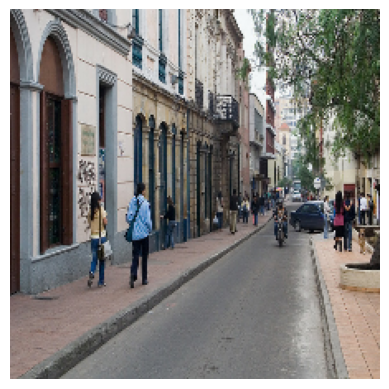

Predicted Caption:  area with a crowd of people walking down the street         


In [ ]:
img_path=train_pairs[280][0]
# print(img_path)
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

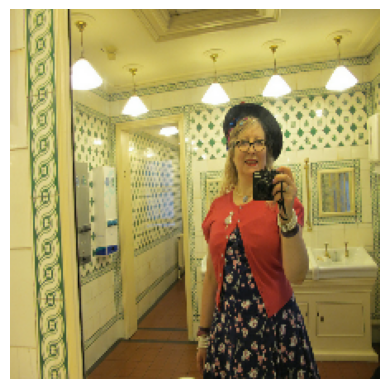

Predicted Caption:  area with a woman standing in front of a mirror         in


In [83]:
img_path=val_pairs[120][0]
# print(img_path)
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

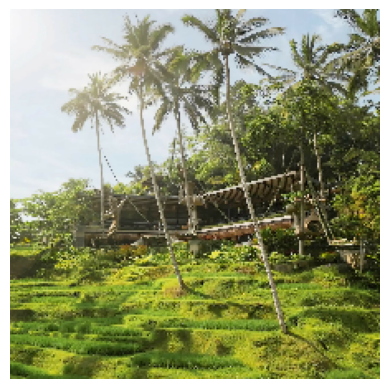

Predicted Caption:  area with a fence and trees and a fence       the fence  


In [86]:
# other image
img_path = 'scenery.jpg'
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

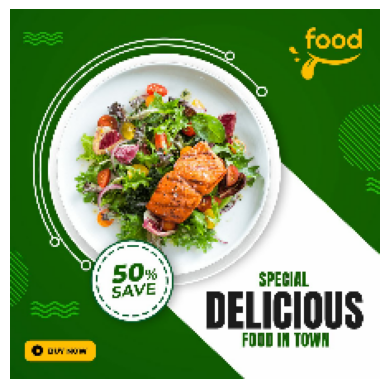

Predicted Caption:  area with a plate of food and a cup of food        


In [87]:
# poster type
img_path = 'poster.jpg'
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

### PLOTTING - updated (history)

In [ ]:
print(history.history.keys())

NameError: name 'history' is not defined

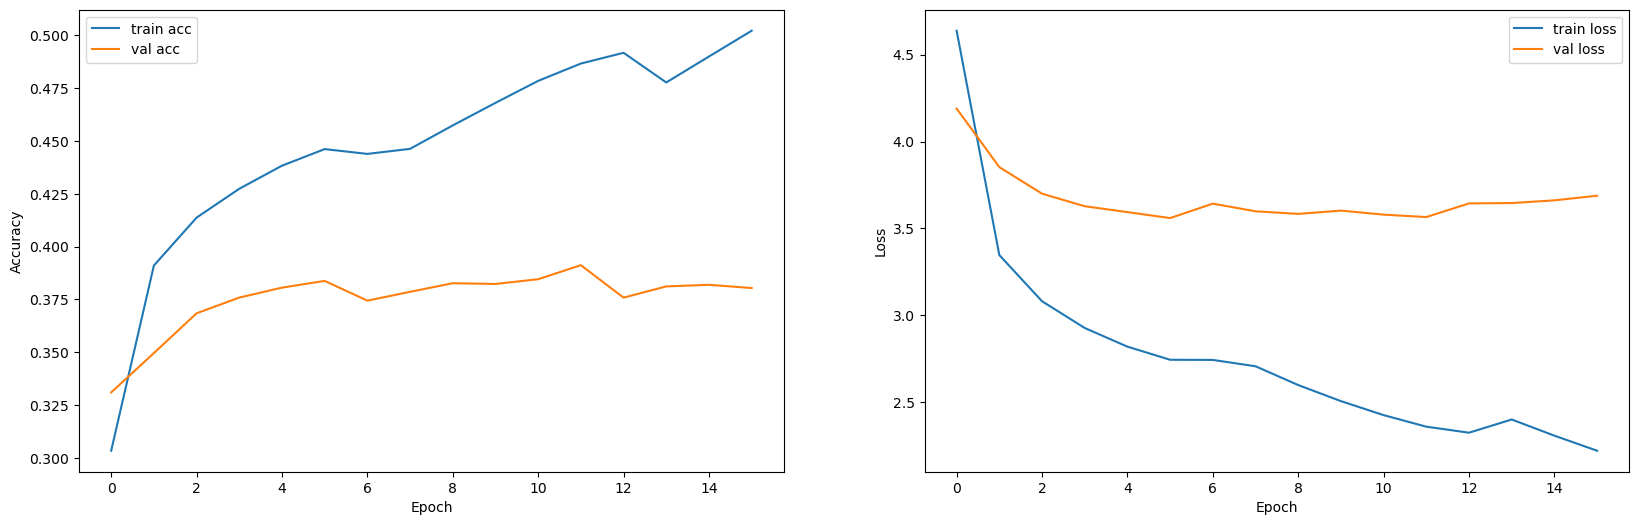

In [ ]:
# 5 epoch newest extraction
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()